In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import *
from particle import *

2024-09-05 17:56:45.682045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 17:56:46.477405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [3]:
synthetic_dataset =  "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_synth"
jrdb_original = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_orig"
jrdb_odometry_processed = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_odom"
eth_augmented = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_eth_aug"
# TODO: crowdbot is missing

test_dataset =  tf.data.Dataset.load(synthetic_dataset)
test_dataset = tf.data.Dataset.unbatch(test_dataset)
test_dataset = test_dataset.batch(1000)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 783722239982921390


# Load model and predict

In [3]:
%matplotlib inline

In [4]:
#model = Kalman_CV(pos_dim=2)
model = IMM_CVCT_2D(pos_dim=2)
#model = IMM_CVCT_3D(pos_dim=3)

In [5]:
for (batch_x1, batch_x2) in test_dataset.take(1):
    predictions = model.predict(batch_x1[:,:,:2])

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 783722239982921390


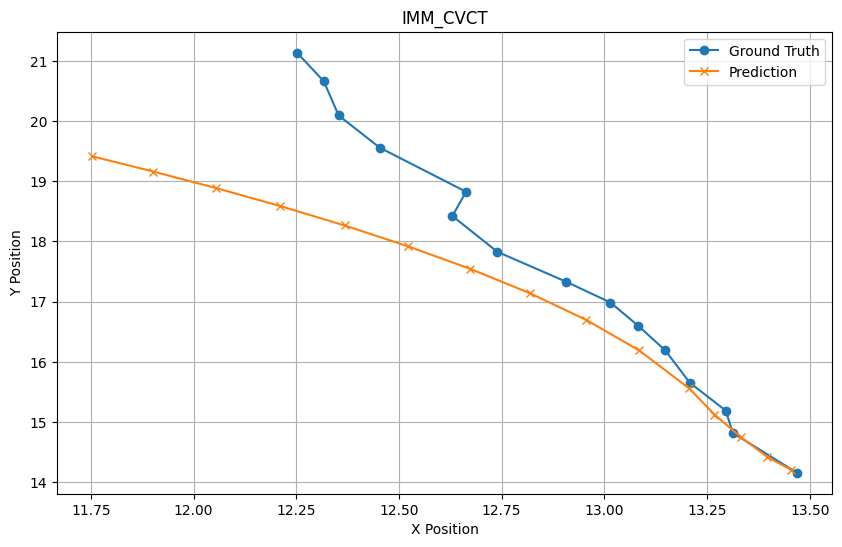

In [6]:
idx = 3
model.plot_predictions(batch_x1[idx:], predictions[idx:], sample_index=0)

# Hyperparameter Optimization

In [7]:
model.hyperparameter_tuning(batch_x1[:,:,:2])

Best Parameters: {'P': 1.0, 'dt': 0.9, 'omega_variance': 1.0, 'q': 0.1, 'r': 0.1}
Best Score: 0.6100979894454925


In [21]:
meanADE = model.calculate_meanADE(batch_x1[:,:,:2], predictions, 2)
meanFDE = model.calculate_meanFDE(batch_x1[:,:,:2], predictions)
print("mean ADE", meanADE)
print("mean FDE", meanFDE)

mean ADE 0.3143453541694528
mean FDE 0.9212957385701512


In [17]:
from sklearn.model_selection import ParameterGrid

# Updated error calculation function to compare only positions
def calculate_meanADE(ground_truth, predictions, dim):
    predicted_positions = predictions[:, :, :dim]
    displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
    ADE = np.mean(np.mean(displacement_errors, axis=1))
    return ADE

# Define the parameter grid
param_grid = {
    'q': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'r': [0.1, 0.2, 0.5, 0.8, 1.0], 
     'P':[0.1, 0.5, 1.0, 10.0], 
    'M': [[[0.9, 0.1],[0.1, 0.9]],
          [[0.8, 0.2],[0.2, 0.8]],
          [[0.6, 0.4],[0.4, 0.6]],
          [[0.5, 0.5],[0.5, 0.5]]
                         ], 
    'dt':  [0.1,0.4,0.9], 
    'omega_variance':[0.1, 0.2, 0.5, 0.8, 1.0]

}

# Generate combinations of parameters
grid = ParameterGrid(param_grid)

best_score = float('inf')
best_params = None

# Grid search loop
for params in grid:
    # Initialize the IMMParticleFilter with current parameters
    model = IMM_CVCT_2D(pos_dim=2)
    model.params['q'] = params['q']
    model.params['r'] = params['r']
    model.params['P'] = params['P']
    model.params['M'] = params['M']
    model.params['dt'] = params['dt']
    model.params['omega_variance'] = params['omega_variance']
    
    # Run the filter on your data and calculate the prediction error
    predictions = model.predict(ds_2d[1][:])
    
    # Calculate the error using the modified function
    error = calculate_meanADE(ds_2d[1][:], predictions, dim=2)

    # Update the best parameters if the current configuration yields a lower error
    if error < best_score:
        best_score = error
        best_params = params

# Print the best hyperparameters and corresponding score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'M': [[0.8, 0.2], [0.2, 0.8]], 'P': 0.1, 'dt': 0.4, 'omega_variance': 1.0, 'q': 1.0, 'r': 0.1}
Best Score: 0.008424381859058607
